## Measuring regional outdoor recreation in the Bay Area using social media, in 3 different categories of land:  
1. Priority Conservation Areas (PCAs),
2. Protected Areas (Bay Area Protected Areas Database - BPAD) 
3. Natural landcover types (NLCD)

### And summarizing how much of the recreation in each category is exposed to sea-level rise, based on 10 different SLR scenarios.

This workflow depends on results from:
    * slr_rasters_align.py
    * userdays_rasteraoi.r
    * ud_rasterize.py

In [1]:
import numpy as np
from osgeo import gdal
gdal.UseExceptions()
import pygeoprocessing.geoprocessing as pgp
import os
import glob
import pandas as pd
import datetime

datestamp = datetime.datetime.now().strftime("%Y-%m-%d")

In [2]:
workspace = '../data/bcdc_slr_regional_rec'

In [3]:
def raster2array(raster_uri):
    '''
    helper function to go straight from raster filename to 2-d numpy array
    '''
    src = gdal.Open(raster_uri)
    band1 = src.GetRasterBand(1)
    rows = src.RasterYSize
    cols = src.RasterXSize
    arr = band1.ReadAsArray(0, 0, cols, rows)
    return(arr)

In [4]:
def burn_aoi2grid(aoi_uri, out_grid_uri, base_grid_uri):
    '''
    helper function to rasterize shapefiles onto a standard grid
    '''
    pgp.new_raster_from_base(base_grid_uri, out_grid_uri, gdal.GDT_Int16, [99], [0])
    pgp.rasterize(aoi_uri, out_grid_uri, [1], None)
    return 0

### All datasources will be rasterized and aligned to the 30m NLCD grid

In [5]:
nlcd_uri = '../data/bcdc_othernaturalareas/NaturalAreas_ForDave/nlcd_nodevt_utm.tif'
nlcd_src = gdal.Open(nlcd_uri)
gt = nlcd_src.GetGeoTransform()
cell_area_km2 = gt[1]*gt[5]*(-1.0)*1e-6
print(cell_area_km2)

0.000908277366174


In [6]:
# PUD raster created by pud_rasterize.py
pud_uri = '../data/flickr/nlcd_grid_pud/pud_nlcdgrid.tif'
pud = raster2array(pud_uri)

In [7]:
# TUD raster created by ud_rasterize.py
tud_uri = '../data/twitter/nlcd_grid_tud/tud_nlcdgrid.tif'
tud = raster2array(tud_uri)

In [8]:
# pgp.new_raster_from_base(nlcd_uri, base_uri, gdal.GDT_Int16, [99], [0])

#### Load AOIs and FEMA flood shapefiles, burn them onto a grid based on the NLCD raster
input datasets must already be NAD_1983_UTM_Zone_10N  
only need to repeat these if an AOI changes

In [9]:
# BPAD 
bpad_uri = os.path.join(workspace, 'bpad.tif')
# shp_uri = '../data/bcdc_othernaturalareas/NaturalAreas_ForDave/BayAreaProtectedLands_utm.shp'
# burn_aoi2grid(shp_uri, bpad_uri, nlcd_uri)

In [10]:
pca_uri = os.path.join(workspace, 'pca.tif')
# shp_uri = '../data/pca/shapefiles/Priority_Conservation_Areas_current.shp'
# burn_aoi2grid(shp_uri, pca_uri, nlcd_uri)

In [11]:
fema100_uri = os.path.join(workspace, 'fema100.tif')
shp_uri = '../data/pca/bcdc_slr/fema/FEMA_100yrFlood_Region_201709.shp'

## for weird reason this doesn't work on these fema shps..raises runtime 'user termintated' error
# burn_aoi2grid(shp_uri, fema100_uri, nlcd_uri)

## also couldn't get this working to yield anything but zeros
# driver = gdal.GetDriverByName('GTiff')
# new_ds = driver.Create(fema100_uri,
#     nlcd_src.RasterXSize, # x size
#     nlcd_src.RasterYSize, # y size
#     1, # number of bands
#     gdal.GDT_Int16)

# gdal.Rasterize(new_ds, shp_uri, burnValues=[1])
# new_ds.SetGeoTransform(nlcd_src.GetGeoTransform())
# new_ds.SetProjection(nlcd_src.GetProjection())
# del new_ds

## resorting to this system call:
# pgp.new_raster_from_base(nlcd_uri, fema100_uri, gdal.GDT_Int16, [99], [0])
# ! gdal_rasterize -burn 1 ../data/pca/bcdc_slr/fema/FEMA_100yrFlood_Region_201709.shp ../data/bcdc_slr_regional_rec/fema100.tif

In [12]:
fema500_uri = os.path.join(workspace, 'fema500.tif')
shp_uri = '../data/pca/bcdc_slr/fema/500yr100yrFlood_9CountyBayArea_201709.shp'
## not working, see above:
# burn_aoi2grid(shp_uri, fema500_uri, nlcd_uri)

## below works:
# pgp.new_raster_from_base(nlcd_uri, fema500_uri, gdal.GDT_Int16, [99], [0])
# ! gdal_rasterize -burn 1 ../data/pca/bcdc_slr/fema/500yr100yrFlood_9CountyBayArea_201709.shp ../data/bcdc_slr_regional_rec/fema500.tif

#### read AOIs as 2d arrays for querying

In [13]:
# Natural Lands - make 2d array 0s and 1s where 1s are all lulc classes other than development
# in the original datasource, development lulc's have already been assigned nodata
band1 = nlcd_src.GetRasterBand(1)
nodata = band1.GetNoDataValue()
rows = nlcd_src.RasterYSize
cols = nlcd_src.RasterXSize
vals = band1.ReadAsArray(0, 0, cols, rows)
nlcd = np.ones_like(vals)
nlcd[vals == nodata] = 0

In [14]:
bpad = raster2array(bpad_uri)
pca = raster2array(pca_uri)
fema100 = raster2array(fema100_uri)
fema500 = raster2array(fema500_uri)

In [15]:
nlcd.shape == bpad.shape == pca.shape == pud.shape == tud.shape == fema100.shape == fema500.shape

True

## Count the photo-user-days across all grid cells included in combinations of the AOIs and SLR scenarios. 

#### All calculations exclude developed areas (based on lulc development classes)

### small example of how these 'presence/absence' arrays are used to count PUDs:

In [16]:
## setting up some toy datasets
np.random.seed(0)
b = np.zeros((5,5)).astype(int)
b[:5,:2] = 1
p = np.zeros((5,5)).astype(int)
p[:2,:3] = 1
s = np.zeros((5,5)).astype(int)
s[[0,4],:5] = 1
u = np.flip(np.random.poisson(size=25).astype(int).reshape(5, 5), 0)

In [17]:
b # could be presence of the BPAD network:

array([[1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0]])

In [18]:
p # could be presence of the PCA network:

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [19]:
s # could be presence of SLR inundation from one scenario

array([[1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1]])

In [20]:
u # could be PUD values to count

array([[0, 0, 0, 1, 1],
       [2, 2, 1, 0, 2],
       [1, 2, 0, 1, 1],
       [1, 0, 0, 5, 1],
       [2, 1, 1, 2, 2]])

#### How many PUDs inside PCA network and exposed to inundation?

In [21]:
print((p == 1) & (s == 1))
np.sum(u[(p == 1) & (s == 1)])

[[ True  True  True False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]


0

#### How many PUDs inside BPAD, outside of PCAs, and exposed to inundation?

In [22]:
print((b == 1) & (p == 0) & (s == 1))
np.sum(u[(b == 1) & (p == 0) & (s == 1)])

[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [ True  True False False False]]


3

#### How many PUDs inside BPAD, outside of PCAs, and outside of inundation?

In [23]:
print((b == 1) & (p == 0) & (s == 0))
np.sum(u[(b == 1) & (p == 0) & (s == 0)])

[[False False False False False]
 [False False False False False]
 [ True  True False False False]
 [ True  True False False False]
 [False False False False False]]


4

### Now the real thing

In [24]:
## Helper function to compile results into a table. 
def tabulate_aoi_totals(nlcd_logic, bpad_logic, pca_logic):
    dataframe = pd.DataFrame(columns=['aoi', 'pud', 'tud', 'area_km2'])
    dataframe['aoi'] = ['nlcd', 'bpad', 'pca']
    dataframe.set_index('aoi', inplace=True)
    
    ## PUD
    dataframe.loc['nlcd', 'pud'] = float(np.sum(pud[nlcd_logic]))
    dataframe.loc['bpad', 'pud'] = float(np.sum(pud[bpad_logic]))
    dataframe.loc['pca', 'pud'] = float(np.sum(pud[pca_logic]))

    ## TUD
    dataframe.loc['nlcd', 'tud'] = float(np.sum(tud[nlcd_logic]))
    dataframe.loc['bpad', 'tud'] = float(np.sum(tud[bpad_logic]))
    dataframe.loc['pca', 'tud'] = float(np.sum(tud[pca_logic]))

    ## Area
    dataframe.loc['nlcd', 'area_km2'] = np.sum((nlcd[nlcd_logic]))*cell_area_km2
    dataframe.loc['bpad', 'area_km2'] = np.sum(nlcd[bpad_logic])*cell_area_km2
    dataframe.loc['pca', 'area_km2'] = np.sum(nlcd[pca_logic])*cell_area_km2
    
    return(dataframe)

## Percent of total regional recreation occurring across different land networks.

### Based on total PUD, TUD, & area in the entire BPAD, PCA, and natural lands (nlcd)
The nlcd grid is always used to exclude areas previously classified as development, and other areas with nodata

In [25]:
nlcd_logic = (nlcd == 1)
bpad_logic = (nlcd == 1) & (bpad == 1)
pca_logic = (nlcd == 1) & (pca == 1)

aoi_totals = tabulate_aoi_totals(nlcd_logic, bpad_logic, pca_logic)
aoi_totals

,pud,tud,area_km2
aoi,,,
nlcd,506887,1.62826e+06,15718
bpad,315934,276680,4937.13
pca,120622,303976,7689.91


In [26]:
# entire PCA and BPAD totals as percent of all natural lands:
aoi_totals/aoi_totals.iloc[0,:]*100

,pud,tud,area_km2
aoi,,,
nlcd,100,100,100
bpad,62.3283,16.9924,31.4107
pca,23.7966,18.6688,48.9243


### Based on total PUD, TUD, & area in the *mutually exclusive* BPAD, PCA, and natural lands (nlcd)
NLCD excludes areas that are BPAD and exludes areas that are PCA. BPAD excludes areas that are also PCA. PCA excludes areas that are also BPAD. The nlcd grid is always used to exclude areas previously classified as development, and other areas with nodata. 

In [27]:
nlcd_logic = (nlcd == 1) & (pca == 0) & (bpad == 0)
bpad_logic = (nlcd == 1) & (bpad == 1) & (pca == 0)
pca_logic = (nlcd == 1) & (pca == 1) & (bpad == 0)
bpad_pca_logic = (nlcd ==1) & (pca ==1) & (bpad ==1)

exclusive_aoi_totals = tabulate_aoi_totals(nlcd_logic, bpad_logic, pca_logic)

## and now the special case where PCA, BPAD, and NLCD are all present:
bpad_pca_df = pd.DataFrame(columns=['aoi', 'pud', 'tud', 'area_km2'])
bpad_pca_df['aoi'] = ['bpad_x_pca']
bpad_pca_df.set_index('aoi', inplace=True)
bpad_pca_df.loc['bpad_x_pca', 'pud'] = float(np.sum(pud[bpad_pca_logic]))
bpad_pca_df.loc['bpad_x_pca', 'tud'] = float(np.sum(tud[bpad_pca_logic]))
bpad_pca_df.loc['bpad_x_pca', 'area_km2'] = np.sum(nlcd[bpad_pca_logic])*cell_area_km2


exclusive_aoi_totals = exclusive_aoi_totals.append(bpad_pca_df)
exclusive_aoi_totals

,pud,tud,area_km2
aoi,,,
nlcd,140413,1.10174e+06,5390.9
bpad,245852,222539,2637.16
pca,50540,249835,5389.95
bpad_x_pca,70082,54141,2299.97


In [28]:
# exclusive PCA, BPAD, NLCD totals as percent of all natural lands:
exclusive_aoi_totals/aoi_totals.iloc[0,:]*100

,pud,tud,area_km2
aoi,,,
nlcd,27.701,67.6638,34.2977
bpad,48.5023,13.6673,16.778
pca,9.97066,15.3437,34.2916
bpad_x_pca,13.826,3.32509,14.6327


### total PUD for each SLR scenario, and with exlcusive AOI pairings (e.g. inside BPAD & outside PCA)

In [29]:
slr_rasters = glob.glob('../data/pca/bcdc_slr/raster/aligned/Inundate*.tif')

In [30]:
# In PCA network, by SLR scenario
pca_slr = {}

for slr_uri in slr_rasters:
    print(slr_uri)
    slr = raster2array(slr_uri)
    assert pud.shape == nlcd.shape == pca.shape == slr.shape
    puds = np.sum(pud[(nlcd == 1) & (pca == 1) & (slr == 1)])
    pca_slr[os.path.basename(slr_uri)] = puds
    
puds_slr0 = np.sum(pud[(nlcd == 1) & (pca == 1)])
pca_slr['Inundate_0'] = puds_slr0

puds_fema100 = np.sum(pud[(nlcd == 1) & (pca == 1) & (fema100 == 1)])
pca_slr['fema100'] = puds_fema100
puds_fema500 = np.sum(pud[(nlcd == 1) & (pca == 1) & (fema500 == 1)])
pca_slr['fema500'] = puds_fema500

../data/pca/bcdc_slr/raster/aligned/Inundate_66.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_77.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_12.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_52.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_108.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_96.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_48.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_24.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_36.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_84.tif


In [31]:
# In BPAD network and not in PCA network, by SLR scenario
bpad_slr = {}

for slr_uri in slr_rasters:
    print(slr_uri)
    slr = raster2array(slr_uri)
    assert pud.shape == nlcd.shape == pca.shape == slr.shape
    puds = np.sum(pud[(nlcd == 1) & (bpad == 1) & (slr == 1) & (pca == 0)])
    bpad_slr[os.path.basename(slr_uri)] = puds
        
puds_slr0 = np.sum(pud[(nlcd == 1) & (bpad == 1) & (pca == 0)])
bpad_slr['Inundate_0'] = puds_slr0

puds_fema100 = np.sum(pud[(nlcd == 1) & (bpad == 1) & (pca == 0) & (fema100 == 1)])
bpad_slr['fema100'] = puds_fema100
puds_fema500 = np.sum(pud[(nlcd == 1) & (bpad == 1) & (pca == 0) & (fema500 == 1)])
bpad_slr['fema500'] = puds_fema500

../data/pca/bcdc_slr/raster/aligned/Inundate_66.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_77.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_12.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_52.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_108.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_96.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_48.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_24.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_36.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_84.tif


In [32]:
# In Natural Lands and not in BPAD and PCA networks, by SLR scenario
nlcd_slr = {}

for slr_uri in slr_rasters:
    print(slr_uri)
    slr = raster2array(slr_uri)
    assert pud.shape == nlcd.shape == pca.shape == slr.shape
    puds = np.sum(pud[(nlcd == 1) & (slr == 1) & (pca == 0) & (bpad == 0)])
    
    nlcd_slr[os.path.basename(slr_uri)] = puds
    
puds_slr0 = np.sum(pud[(nlcd == 1) & (pca == 0) & (bpad == 0)])
nlcd_slr['Inundate_0'] = puds_slr0

puds_fema100 = np.sum(pud[(nlcd == 1) & (pca == 0) & (bpad == 0) & (fema100 == 1)])
nlcd_slr['fema100'] = puds_fema100
puds_fema500 = np.sum(pud[(nlcd == 1) & (pca == 0) & (bpad == 0) & (fema500 == 1)])
nlcd_slr['fema500'] = puds_fema500

../data/pca/bcdc_slr/raster/aligned/Inundate_66.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_77.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_12.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_52.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_108.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_96.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_48.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_24.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_36.tif
../data/pca/bcdc_slr/raster/aligned/Inundate_84.tif


### Compile scenario results

In [33]:
pca_df = pd.DataFrame(pca_slr.items(), columns=['scenario', 'pca'])
bpad_df = pd.DataFrame(bpad_slr.items(), columns=['scenario', 'bpad'])
nlcd_df = pd.DataFrame(nlcd_slr.items(), columns=['scenario', 'nlcd'])

In [34]:
results = pd.merge(pd.merge(pca_df, bpad_df, on='scenario'), nlcd_df, on='scenario')

In [35]:
pca_total = results[results['scenario'] == 'Inundate_0']['pca']
bpad_total = results[results['scenario'] == 'Inundate_0']['bpad']
nlcd_total = results[results['scenario'] == 'Inundate_0']['nlcd']

In [36]:
results['pca_pr'] = results['pca'].apply(lambda x: x/pca_total*100)
results['bpad_pr'] = results['bpad'].apply(lambda x: x/bpad_total*100)
results['nlcd_pr'] = results['nlcd'].apply(lambda x: x/nlcd_total*100)

In [37]:
fema_results = results[results['scenario'].isin(['fema100', 'fema500'])]
results = results[~results['scenario'].isin(['fema100', 'fema500'])]

### Percent of PUD in exposed area for each scenario
#### For each AOI, percent is relative to that AOI's '0 inundation' scenario

In [38]:
results['slr_inches'] = pd.to_numeric(results['scenario'].str.extract('([0-9]?[0-9]?[0-9])'))

/home/dmf/miniconda3/envs/geowork2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


In [39]:
results.sort_values(by='slr_inches')

,scenario,pca,bpad,nlcd,pca_pr,bpad_pr,nlcd_pr,slr_inches
2,Inundate_0,120622,245852,140413,100.000000,100.000000,100.000000,0
12,Inundate_12.tif,1332,3364,4274,1.104276,1.368303,3.043878,12
9,Inundate_24.tif,3079,4381,5615,2.552602,1.781966,3.998917,24
0,Inundate_36.tif,3469,6871,6974,2.875926,2.794771,4.966777,36
1,Inundate_48.tif,4945,8189,9022,4.099584,3.330866,6.425331,48
11,Inundate_52.tif,5037,8736,10383,4.175855,3.553357,7.394614,52
5,Inundate_66.tif,5396,16157,14624,4.473479,6.571840,10.414990,66
6,Inundate_77.tif,7767,17554,20666,6.439124,7.140068,14.718010,77
8,Inundate_84.tif,7883,18493,21556,6.535292,7.522005,15.351855,84
4,Inundate_96.tif,8012,19743,23717,6.642238,8.030441,16.890886,96


In [40]:
fema_results

,scenario,pca,bpad,nlcd,pca_pr,bpad_pr,nlcd_pr
3,fema500,24366,35990,39104,20.200295,14.638888,27.849273
7,fema100,20236,30992,31405,16.776376,12.605958,22.366163


In [41]:
results.to_csv(os.path.join(workspace, 'results' + datestamp + '.csv'), index=False)
fema_results.to_csv(os.path.join(workspace, 'results_fema' + datestamp + '.csv'), index=False)

### Make scenario plot

In [42]:
import plotnine as gg
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = "11, 8"

workspace = '../data/bcdc_slr_regional_rec'

/home/dmf/miniconda3/envs/geowork2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [43]:
# load slr scenario results for plotting
data = pd.read_csv(os.path.join(workspace, 'results' + datestamp + '.csv'))
data.columns = ['scenario', 'pca', 'bpad', 'natural_lands', 'pca_pr', 'bpad_pr', 'natural_lands_pr', 'TWL']
df = data.melt(id_vars='TWL', value_vars=['pca_pr', 'bpad_pr', 'natural_lands_pr'], \
          value_name='percent_pud_exposed')
df['variable'] = pd.Categorical(df['variable'], categories=['pca_pr', 'bpad_pr', 'natural_lands_pr'])
df.head()

,TWL,variable,percent_pud_exposed
0,36,pca_pr,2.875926
1,48,pca_pr,4.099584
2,0,pca_pr,100.000000
3,96,pca_pr,6.642238
4,66,pca_pr,4.473479


In [44]:
# load fema scenario results for plotting
fema = pd.read_csv(os.path.join(workspace, 'results_fema' + datestamp + '.csv'))
fema.head()

,scenario,pca,bpad,nlcd,pca_pr,bpad_pr,nlcd_pr
0,fema500,24366,35990,39104,20.200295,14.638888,27.849273
1,fema100,20236,30992,31405,16.776376,12.605958,22.366163


In [45]:
cat_colors = ['#B9ED29', '#44B1AC', '#EB922D']

In [46]:
# plot = gg.ggplot(df[df['TWL'] != 0], gg.aes(x='TWL', y='percent_pud_exposed', fill='variable')) +\
# gg.geom_bar(stat='identity', position='dodge', width=4) +\
# gg.scale_x_continuous(breaks=df[df['TWL'] != 0]['TWL']) +\
# gg.scale_fill_manual(values=cat_colors) +\
# gg.theme_classic()

# plotpath = os.path.join(workspace, 'rec_barplot.png')
# plot.save(filename=plotpath, width=10, height=6)

In [47]:
# from IPython.display import Image
# Image(plotpath)

In [48]:
plot = gg.ggplot(df[df['TWL'] != 0], gg.aes(x='TWL', y='percent_pud_exposed', fill='variable')) +\
gg.geom_line(gg.aes(color='variable')) +\
gg.geom_point(size=5, stroke=0.25) +\
gg.scale_x_continuous(breaks=df[df['TWL'] != 0]['TWL']) +\
gg.scale_fill_manual(values=cat_colors) +\
gg.scale_color_manual(values=cat_colors) +\
gg.theme_classic() +\
gg.theme(axis_text=gg.element_text(size=12), axis_title=gg.element_text(size=14))

plotpath = os.path.join(workspace, 'rec_lineplot.png')
plot.save(filename=plotpath, width=10, height=6)

/home/dmf/miniconda3/envs/geowork2/lib/python2.7/site-packages/plotnine/ggplot.py:688: UserWarning: Saving 10 x 6 in image.
  from_inches(height, units), units))
/home/dmf/miniconda3/envs/geowork2/lib/python2.7/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: ../data/bcdc_slr_regional_rec/rec_lineplot.png
  warn('Filename: {}'.format(filename))


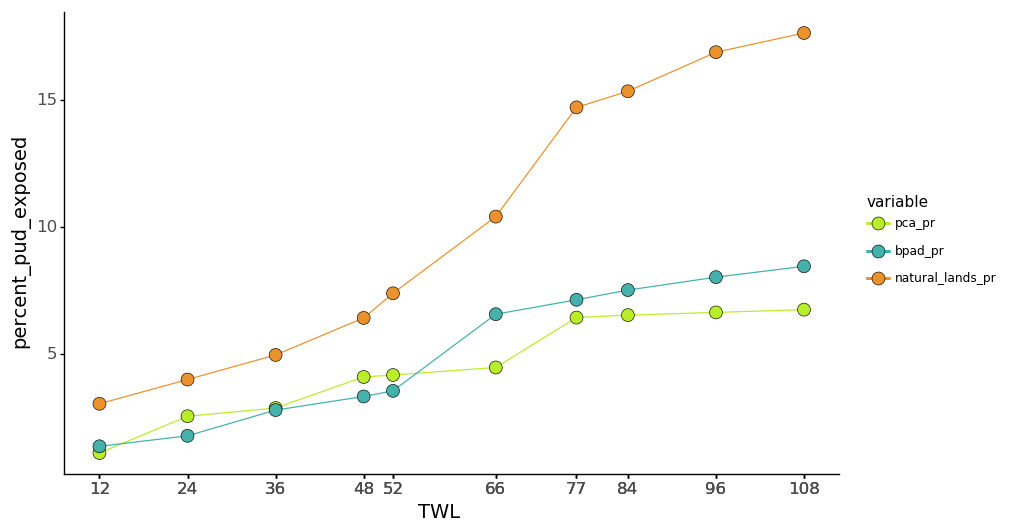

In [49]:
from IPython.display import Image
Image(plotpath)

In [50]:
df = data.melt(id_vars='TWL', value_vars=['pca', 'bpad', 'natural_lands'], \
          value_name='total_pud_exposed')
df['variable'] = pd.Categorical(df['variable'], categories=['pca', 'bpad', 'natural_lands'])

In [51]:
plot = gg.ggplot(df[df['TWL'] != 0], gg.aes(x='TWL', y='total_pud_exposed', fill='variable')) +\
gg.geom_line(gg.aes(color='variable')) +\
gg.geom_point(size=5, stroke=0.25) +\
gg.scale_x_continuous(breaks=df[df['TWL'] != 0]['TWL']) +\
gg.scale_fill_manual(values=cat_colors) +\
gg.scale_color_manual(values=cat_colors) +\
gg.theme_classic() +\
gg.theme(axis_text=gg.element_text(size=12), axis_title=gg.element_text(size=14))

plotpath = os.path.join(workspace, 'rec_lineplot_totals.png')
plot.save(filename=plotpath, width=10, height=6)

/home/dmf/miniconda3/envs/geowork2/lib/python2.7/site-packages/plotnine/ggplot.py:689: UserWarning: Filename: ../data/bcdc_slr_regional_rec/rec_lineplot_totals.png
  warn('Filename: {}'.format(filename))


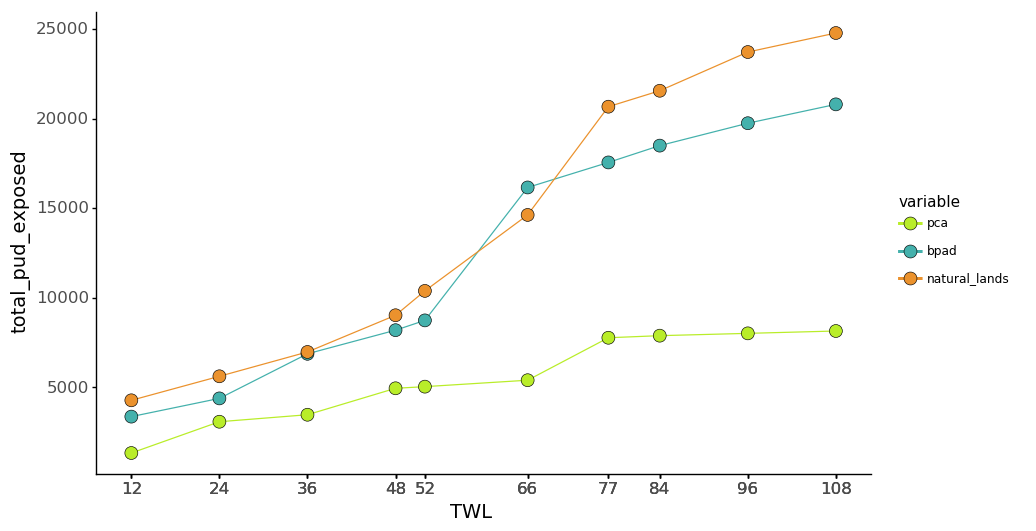

In [52]:
from IPython.display import Image
Image(plotpath)